# More intuitions for APT
I'm currently confusing myself about how exactly PyTorch applies matmuls in linear layers and the other operations in my APT stack with tensor splitting etc. The purpose of this NB is to trace these ops more carefully.

## Setup

In [1]:
import torch
import sys
import os
sys.path.append('..')  # or the actual path to your project root

from src.arithmetic_pretrained_transformer import APT, APTConfig, DataLoaderLite
from src.arithmetic_tokenizer import ArithmeticTokenizer


from tqdm import tqdm

# Environment prep
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.mps.manual_seed(42)
torch.set_printoptions(sci_mode=False)


# ------------------------------------------TRAINING-----------------------------------------------------------
# attempt to auto recognize the device!
device = "cpu"
if torch.cuda.is_available(): device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): device = "mps"
print(f"using device {device}")

with_bos = False
vocab_path = '../tokenizer_variations/sum_0-9+special_vocab.json'
num_tokens_per_sample = 11
data_location = '../datasets/no_bos_no_eos/499by499.json'

listdir = os.listdir()
print(listdir)

# MODEL SETUP
tokenizer = ArithmeticTokenizer(vocab_path, max_length=num_tokens_per_sample, padding="max_length")
config = APTConfig(vocab_size=len(tokenizer._id_tokens),
                   block_size=num_tokens_per_sample,
                   n_layer=3,
                   n_head=4,
                   n_embd=8,
                   bias=True,
                   pos_embd='learned',
                   )
print(f"VOCAB SIZE IS {config.vocab_size}")
model = APT(config)
model.to(device)
model.device = device
model.tokenizer = tokenizer


# HYPERPARAMETERS AND UTILITIES FOR TRAINING, EVAL DATASET PREP
batch_size = 2048 #1024 works?
train_loader = DataLoaderLite(
    B=batch_size, 
    T=num_tokens_per_sample, 
    data_location=data_location, 
    tokenizer=tokenizer,
    eval_percentage=0.01
    )
learning_rate = 0.04
trainset_size = train_loader.trainset_size
epochs = int(125 * 1)
max_steps = epochs * (trainset_size) // batch_size
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.02) # easy gains: decrease weights for different language tokens!

using device mps


/Users/s2011847/repos/APT/.apt_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device mps
['fun_with_manim.ipynb', 'more_intuitions_for_APT.ipynb', 'play.ipynb', 'generate_dataset.ipynb', 'mlp_animated.ipynb', 'fun_with_matrices.ipynb']
VOCAB SIZE IS 17
Add different options for learned vs rotational vs alibi positional encodings!!!
we have self.trainset_size 247499
loaded 2722489 tokens
1 epoch = 10 batches


In [1]:
for step in tqdm(range(max_steps), dynamic_ncols=True):
    model.train()
    x, y = train_loader.next_batch_train()
    x, y = x.to(device), y.to(device)
    # y[:,0:5] = -100
    optimizer.zero_grad() # always need to start with 0 gradient
    logits, loss = model(x, y)
    loss.backward() # this adds to gradients! which is why we need to zero_grad
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    # norm = 1
    optimizer.step() # this actually updates the params

NameError: name 'tqdm' is not defined

# Let's load apt from save and see what it looks like

In [14]:
import torch
from torch.autograd.functional import hessian
from torch.nn import functional as F
import matplotlib as plt

import sys
sys.path.insert(0, '..')

from src.arithmetic_pretrained_transformer import APT, APTConfig, DataLoaderLite, DataLoaderPyTorch
from src.arithmetic_tokenizer import ArithmeticTokenizer


torch.set_printoptions(
    sci_mode=False, 
    threshold=10_000,
    edgeitems=3,
    )

device = "cuda:0"
model_file_id = "../apt_checkpoints/base/6_1_3_32_800_e.pt"
state_dict = torch.load(model_file_id, weights_only=False, map_location=device)

loss_fn = F.cross_entropy

# we need x and y from somewhere

batch_size = 4096
vocab_path = '../tokenizer_variations/sum_0-9+special_vocab.json'
num_tokens_per_sample = 11
data_location = '../datasets/no_bos_no_eos/499by499.json'
tokenizer = ArithmeticTokenizer(vocab_path, max_length=num_tokens_per_sample, padding="max_length")

config = APTConfig(vocab_size=len(tokenizer._id_tokens),
                   block_size=num_tokens_per_sample,
                   n_layer=6,
                   n_head=1,
                   n_embd=3,
                   mlp_expansion_factor=32,
                   bias=True,
                   pos_embd='learned',
                   )
print(f"VOCAB SIZE IS {config.vocab_size}")
model = APT(config)
# now load state dict into model
model.load_state_dict(state_dict)
model = model.to(device)

VOCAB SIZE IS 17
Add different options for learned vs rotational vs alibi positional encodings!!!
Swap layernorm to RMSNorm!


In [15]:
train_loader = DataLoaderPyTorch(
    B=batch_size, 
    T=num_tokens_per_sample, 
    data_location=data_location, 
    tokenizer=tokenizer,
    eval_percentage=0.01,
    num_workers=0,
)
x, y = train_loader.next_batch_train()
x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

we have self.trainset_size 247500, and num_eval 2500
loaded 2722500 tokens
1 epoch = 60 batches
Eval split: 1-digit 0.0%, 2-digit 1.8%, 3-digit 98.2%


In [21]:
#this is all claude code
from tqdm import tqdm

def get_gradient_and_curvature_directions(model, loss_fn, x, y):
    # Compute gradient w.r.t. actual model parameters, then vectorize
    model.zero_grad()
    logits, _ = model(x)
    loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
    loss.backward(create_graph=True)
    
    # Collect gradients into a vector
    grad = torch.cat([p.grad.flatten() for p in model.parameters()])
    grad_dir = grad / grad.norm()
    
    # For Hessian, we need a fresh function that keeps params in graph
    params = torch.nn.utils.parameters_to_vector(model.parameters()).detach().clone()
    
    def loss_wrapper(p):
        # This creates a fresh forward pass with p in the graph
        torch.nn.utils.vector_to_parameters(p, model.parameters())
        logits, _ = model(x)
        return loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
    
    # Compute Hessian
    H = torch.autograd.functional.hessian(loss_wrapper, params)
    
    # Restore original parameters
    torch.nn.utils.vector_to_parameters(params, model.parameters())
    
    eigenvalues, eigenvectors = torch.linalg.eigh(H)
    sharp_dir = eigenvectors[:, -1]
    
    # Orthogonalize sharp_dir w.r.t. gradient for cleaner visualization
    sharp_dir_orth = sharp_dir - sharp_dir.dot(grad_dir) * grad_dir
    sharp_dir_orth = sharp_dir_orth / sharp_dir_orth.norm()
    
    # Alignment between gradient and sharpest direction
    alignment = torch.abs(grad_dir.dot(eigenvectors[:, -1]))
    
    return grad_dir.detach(), sharp_dir_orth.detach(), alignment.item()


def visualize_loss_landscape(model, loader, dir1, dir2, 
                              steps=50, range_=1.0, n_batches=5,
                              dir1_name='Direction 1', dir2_name='Direction 2'):
    original = torch.nn.utils.parameters_to_vector(model.parameters()).clone()
    
    losses = torch.zeros(steps, steps)
    alphas = torch.linspace(-range_, range_, steps)
    
    with torch.no_grad():
        for i, a1 in enumerate(tqdm(alphas, desc='Landscape')):
            for j, a2 in enumerate(alphas):
                new_params = original + a1 * dir1 + a2 * dir2
                torch.nn.utils.vector_to_parameters(new_params, model.parameters())
                
                # Average over multiple batches for stability
                batch_losses = []
                for _ in range(n_batches):
                    x, y = loader.next_batch_eval()
                    x, y = x.to(device), y.to(device)
                    _, loss = model(x, y)
                    batch_losses.append(loss.item())
                losses[i, j] = sum(batch_losses) / len(batch_losses)
    
    torch.nn.utils.vector_to_parameters(original, model.parameters())
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Contour plot
    cf = axes[0].contourf(alphas.cpu(), alphas.cpu(), losses.cpu().T, levels=50, cmap='viridis')
    axes[0].plot(0, 0, 'r*', markersize=15, label='Current params')
    axes[0].set_xlabel(dir1_name)
    axes[0].set_ylabel(dir2_name)
    axes[0].legend()
    plt.colorbar(cf, ax=axes[0], label='Loss')
    
    # 3D surface
    ax3d = fig.add_subplot(1, 3, 2, projection='3d')
    X, Y = torch.meshgrid(alphas, alphas, indexing='ij')
    ax3d.plot_surface(X.cpu(), Y.cpu(), losses.cpu(), cmap='viridis', alpha=0.8)
    ax3d.set_xlabel(dir1_name)
    ax3d.set_ylabel(dir2_name)
    ax3d.set_zlabel('Loss')
    
    # Cross-sections through origin
    mid = steps // 2
    axes[2].plot(alphas.cpu(), losses[mid, :].cpu(), label=f'Along {dir2_name}')
    axes[2].plot(alphas.cpu(), losses[:, mid].cpu(), label=f'Along {dir1_name}')
    axes[2].axvline(x=0, color='r', linestyle='--', alpha=0.5)
    axes[2].set_xlabel('Distance from current params')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    
    plt.tight_layout()
    return fig, losses

In [24]:
@torch.no_grad()
def visualize_loss_landscape_fast(model, loader, dir1, dir2, 
                                   steps=50, range_=1.0, n_batches=5,
                                   dir1_name='Direction 1', dir2_name='Direction 2'):
    """Batched version - evaluate many parameter configs at once."""
    original = torch.nn.utils.parameters_to_vector(model.parameters()).clone()
    device = original.device
    
    alphas = torch.linspace(-range_, range_, steps, device=device)
    
    # Precompute all parameter perturbations
    # Shape: (steps, steps, n_params)
    a1_grid, a2_grid = torch.meshgrid(alphas, alphas, indexing='ij')
    perturbations = (a1_grid.reshape(-1, 1) * dir1.unsqueeze(0) + 
                     a2_grid.reshape(-1, 1) * dir2.unsqueeze(0))  # (steps², n_params)
    
    # Get eval batches upfront
    eval_batches = []
    for _ in range(n_batches):
        x, y = loader.next_batch_eval()
        eval_batches.append((x.to(device), y.to(device)))
    
    losses = torch.zeros(steps * steps, device=device)
    
    # Still need to iterate (can't batch through model params), but minimize overhead
    for i, perturb in enumerate(tqdm(perturbations, desc='Landscape')):
        torch.nn.utils.vector_to_parameters(original + perturb, model.parameters())
        
        batch_loss = 0
        for x, y in eval_batches:
            logits, _ = model(x)
            batch_loss += F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1)).item()
        losses[i] = batch_loss / n_batches
    
    torch.nn.utils.vector_to_parameters(original, model.parameters())
    losses = losses.reshape(steps, steps)
    
    # Plot
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(15, 4))
    
    ax1 = fig.add_subplot(1, 3, 1)
    cf = ax1.contourf(alphas.cpu(), alphas.cpu(), losses.cpu().T, levels=50, cmap='viridis')
    ax1.plot(0, 0, 'r*', markersize=15, label='Current params')
    ax1.set_xlabel(dir1_name)
    ax1.set_ylabel(dir2_name)
    ax1.legend()
    plt.colorbar(cf, ax=ax1, label='Loss')
    
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    X, Y = torch.meshgrid(alphas, alphas, indexing='ij')
    ax2.plot_surface(X.cpu().numpy(), Y.cpu().numpy(), losses.cpu().numpy(), cmap='viridis', alpha=0.8)
    ax2.set_xlabel(dir1_name)
    ax2.set_ylabel(dir2_name)
    ax2.set_zlabel('Loss')
    
    ax3 = fig.add_subplot(1, 3, 3)
    mid = steps // 2
    ax3.plot(alphas.cpu(), losses[mid, :].cpu(), label=f'Along {dir2_name}')
    ax3.plot(alphas.cpu(), losses[:, mid].cpu(), label=f'Along {dir1_name}')
    ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Distance from current params')
    ax3.set_ylabel('Loss')
    ax3.legend()
    
    plt.tight_layout()
    return fig, losses, alphas

Gradient-curvature alignment: 0.000


Landscape: 100%|██████████| 2500/2500 [00:41<00:00, 59.77it/s]


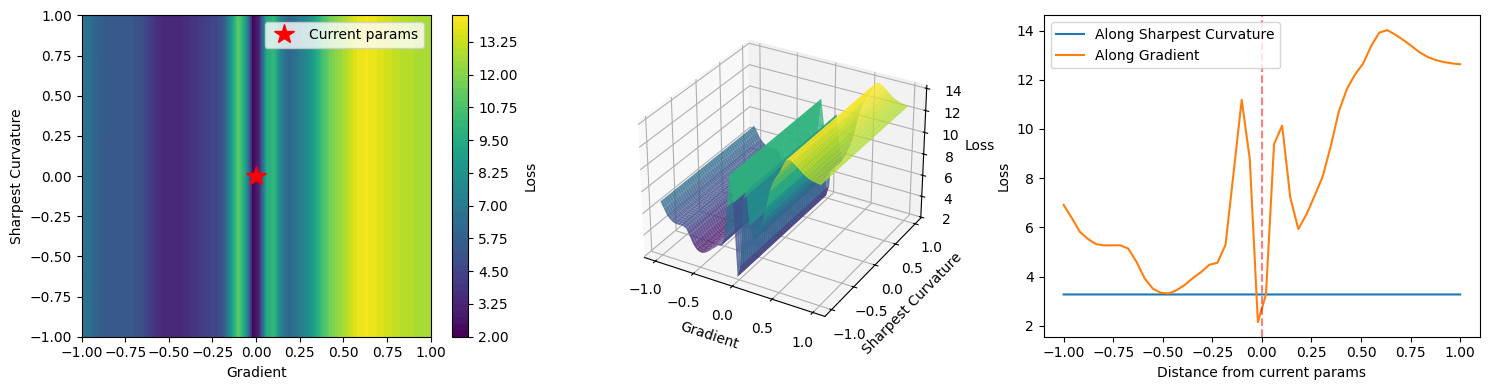

In [26]:

# Example usage - Gradient vs Sharpest Curvature
grad_dir, sharp_dir, alignment = get_gradient_and_curvature_directions(
    model, F.cross_entropy, x, y
)
print(f"Gradient-curvature alignment: {alignment:.3f}")

fig, losses, alphas = visualize_loss_landscape_fast(
    model, train_loader, grad_dir, sharp_dir,
    dir1_name='Gradient', dir2_name='Sharpest Curvature'
)